<a href="https://colab.research.google.com/github/ameralhomdy/DS-Unit-2-Applied-Modeling/blob/master/module2/assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
import pandas as pd

ufc = pd.read_csv('ufc_combined.csv')

In [3]:
ufc.head()

,Unnamed: 0,fighter1,fighter2,winner,weight_class,title_fight,method,end_round,fight_year,win_fighter1,lose_fighter1,draw_fighter1,nc_fighter1,height_fighter1,reach_fighter1,stance_fighter1,SLpM_fighter1,Str_Acc_fighter1,SApM_fighter1,Str_Def_fighter1,TD_Avg_fighter1,TD_Acc_fighter1,TD_Def_fighter1,Sub_Avg_fighter1,win%_fighter1,born_year_fighter1,win_fighter2,lose_fighter2,draw_fighter2,nc_fighter2,height_fighter2,reach_fighter2,stance_fighter2,SLpM_fighter2,Str_Acc_fighter2,SApM_fighter2,Str_Def_fighter2,TD_Avg_fighter2,TD_Acc_fighter2,TD_Def_fighter2,Sub_Avg_fighter2,win%_fighter2,born_year_fighter2
0,0,Santiago Ponzinibbio,Neil Magny,1,Welterweight,f,KO/TKO,4,2018,28,3,0,0,"6' 0""","73""",Orthodox,4.27,39.0,4.02,64.0,0.54,44.0,60.0,0.0,90.322580,1986,21,8,0,0,"6' 3""","80""",Orthodox,3.86,46.0,2.22,56.0,2.62,46.0,60.0,0.3,72.413795,1987
1,1,Ricardo Lamas,Darren Elkins,1,Featherweight,f,KO/TKO,3,2018,19,7,0,0,"5' 8""","71""",Orthodox,2.87,45.0,2.61,59.0,1.66,32.0,47.0,1.0,73.076920,1982,25,7,0,0,"5' 10""","71""",Orthodox,3.36,37.0,2.83,53.0,2.68,35.0,57.0,1.3,78.125000,1984
2,2,Johnny Walker,Khalil Rountree Jr.,1,Light Heavyweight,f,KO/TKO,1,2018,15,3,0,0,"6' 5""","82""",Orthodox,5.37,70.0,3.36,25.0,0.89,100.0,100.0,2.6,83.333336,1992,8,2,0,2,"6' 1""","76""",Southpaw,2.30,34.0,3.29,38.0,0.00,0.0,50.0,0.3,66.666664,1990
3,3,Cezar Ferreira,Ian Heinisch,0,Middleweight,f,DEC,3,2018,14,7,0,0,"6' 1""","78""",Southpaw,1.83,42.0,2.14,55.0,2.97,59.0,90.0,0.5,66.666664,1985,12,1,0,0,"5' 11""",NaN,Orthodox,3.49,58.0,1.67,52.0,0.81,14.0,50.0,1.6,92.307690,1988
4,4,Marlon Vera,Guido Cannetti,1,Bantamweight,f,SUB,2,2018,12,5,1,0,"5' 8""","70""",Switch,3.23,44.0,3.93,52.0,0.78,37.0,68.0,1.3,66.666664,1992,8,5,0,0,"5' 6""","68""",Southpaw,2.80,52.0,1.95,51.0,2.80,50.0,75.0,0.3,61.538460,1979


In [4]:
ufc.describe()

,Unnamed: 0,winner,end_round,fight_year,win_fighter1,lose_fighter1,draw_fighter1,nc_fighter1,SLpM_fighter1,Str_Acc_fighter1,SApM_fighter1,Str_Def_fighter1,TD_Avg_fighter1,TD_Acc_fighter1,TD_Def_fighter1,Sub_Avg_fighter1,win%_fighter1,win_fighter2,lose_fighter2,draw_fighter2,nc_fighter2,SLpM_fighter2,Str_Acc_fighter2,SApM_fighter2,Str_Def_fighter2,TD_Avg_fighter2,TD_Acc_fighter2,TD_Def_fighter2,Sub_Avg_fighter2,win%_fighter2
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.00000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.00000,4591.000000,4591.000000
mean,2295.000000,0.499673,2.318449,2012.485297,18.209105,7.067523,0.261163,0.203659,3.038713,42.788717,3.056970,55.850577,1.641361,39.383577,58.440427,0.736572,71.046464,17.885864,6.962535,0.267480,0.20758,3.051292,43.051841,3.104025,55.824875,1.651261,39.726203,58.18166,0.748203,71.077670
std,1325.451873,0.500054,0.995680,4.340787,9.189879,4.160795,0.706932,0.445402,1.162678,8.574358,1.169775,8.501666,1.279802,20.674738,21.743992,0.877644,10.093916,8.642326,4.149115,0.705338,0.44750,1.211596,8.512936,1.249050,8.381159,1.315888,20.968619,22.41266,0.878889,10.413941
min,0.000000,0.000000,1.000000,1993.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1147.500000,0.000000,1.000000,2010.000000,12.000000,4.000000,0.000000,0.000000,2.220000,38.000000,2.300000,51.000000,0.650000,28.000000,47.000000,0.100000,64.285710,12.000000,4.000000,0.000000,0.00000,2.220000,38.000000,2.330000,51.000000,0.650000,28.000000,47.00000,0.100000,64.285710
50%,2295.000000,0.000000,3.000000,2013.000000,17.000000,6.000000,0.000000,0.000000,2.960000,43.000000,2.880000,56.000000,1.390000,40.000000,61.000000,0.500000,71.428570,17.000000,6.000000,0.000000,0.00000,2.970000,43.000000,2.940000,57.000000,1.400000,40.000000,62.00000,0.500000,71.428570
75%,3442.500000,1.000000,3.000000,2016.000000,23.000000,10.000000,0.000000,0.000000,3.710000,48.000000,3.620000,62.000000,2.460000,50.000000,73.000000,1.000000,77.777780,23.000000,9.000000,0.000000,0.00000,3.710000,48.000000,3.640000,62.000000,2.410000,50.000000,73.00000,1.000000,77.777780
max,4590.000000,1.000000,5.000000,2018.000000,88.000000,33.000000,10.000000,3.000000,10.830000,100.000000,12.920000,81.000000,11.110000,100.000000,100.000000,16.400000,100.000000,88.000000,27.000000,8.000000,2.00000,12.940000,100.000000,22.500000,100.000000,13.950000,100.000000,100.00000,12.100000,100.000000


In [6]:
baseline_score = 1 - 0.499673
baseline_score

0.500327

In [7]:
# checking NaN values

ufc.isnull().sum()

Unnamed: 0              0
fighter1                0
fighter2                0
winner                  0
weight_class            0
title_fight             0
method                  0
end_round               0
fight_year              0
win_fighter1            0
lose_fighter1           0
draw_fighter1           0
nc_fighter1             0
height_fighter1         3
reach_fighter1        317
stance_fighter1       126
SLpM_fighter1           0
Str_Acc_fighter1        0
SApM_fighter1           0
Str_Def_fighter1        0
TD_Avg_fighter1         0
TD_Acc_fighter1         0
TD_Def_fighter1         0
Sub_Avg_fighter1        0
win%_fighter1           0
born_year_fighter1      0
win_fighter2            0
lose_fighter2           0
draw_fighter2           0
nc_fighter2             0
height_fighter2         0
reach_fighter2        313
stance_fighter2       121
SLpM_fighter2           0
Str_Acc_fighter2        0
SApM_fighter2           0
Str_Def_fighter2        0
TD_Avg_fighter2         0
TD_Acc_fight

In [0]:
# dropping columns that we won't have info on for predicting in the future

dropped_columns = ['method', 'end_round', 'Unnamed: 0', 'stance_fighter1', 'stance_fighter2']

ufc = ufc.drop(columns=dropped_columns)

In [13]:
ufc['fight_year'].value_counts()

2014    494
2016    483
2015    464
2017    446
2018    397
2013    376
2012    333
2011    295
2010    250
2009    213
2008    201
2007    168
2006    158
2005     79
2002     52
2003     39
2004     39
2001     39
2000     23
1999     14
1997     10
1998     10
1996      6
1993      1
1994      1
Name: fight_year, dtype: int64

In [18]:
# splitting into test and train
train = ufc[ufc['fight_year'] <= 2016]
test = ufc[ufc['fight_year'] > 2016]

train.shape, test.shape

((3748, 38), (843, 38))

In [0]:
# splitting into X features and y target

target = 'winner'

X_train = train.drop(columns=[target])
y_train = train[target]
X_test = test.drop(columns=[target])
y_test = test[target]

In [66]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

model = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_test_transformed)

print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.7295373665480427


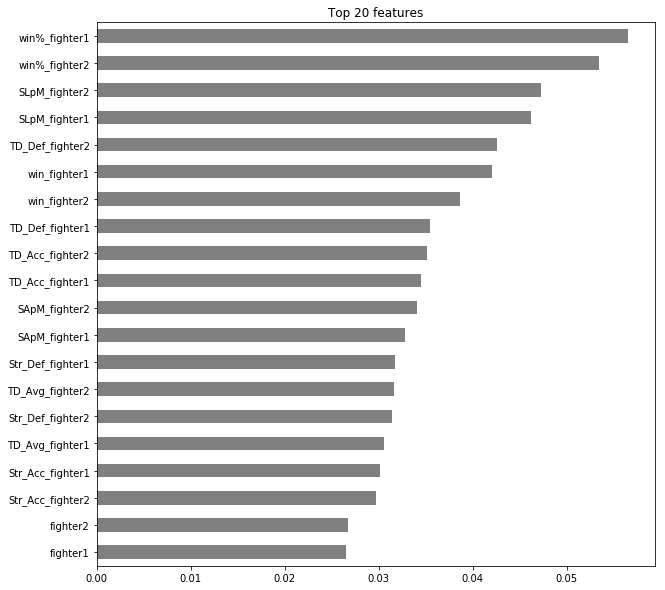

In [28]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [39]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_test_transformed, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [41]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0536 ± 0.0110,win%_fighter2
0.0524 ± 0.0178,win%_fighter1
0.0059 ± 0.0089,SLpM_fighter2
0.0052 ± 0.0088,win_fighter2
0.0024 ± 0.0062,SApM_fighter2
0.0021 ± 0.0160,Str_Def_fighter1
0.0019 ± 0.0101,Str_Def_fighter2
0.0005 ± 0.0084,lose_fighter1
0.0005 ± 0.0074,TD_Acc_fighter1
0.0002 ± 0.0028,nc_fighter2


In [0]:
TD_Def_fighter1
Str_Acc_fighter2
TD_Def_fighter2
Str_Acc_fighter1
born_year_fighter2
born_year_fighter1
height_fighter1
height_fighter2


In [46]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train.shape, X_test.shape, X_train_encoded.shape, X_test_encoded.shape

((3748, 37), (843, 37), (3748, 37), (843, 37))

In [50]:
y_train.shape

(3748,)

In [62]:
# XGBoost
from xgboost import XGBClassifier

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.3, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='error', early_stopping_rounds=50)

[0]	validation_0-error:0.265742	validation_1-error:0.338078
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.22412	validation_1-error:0.320285
[2]	validation_0-error:0.196371	validation_1-error:0.304864
[3]	validation_0-error:0.189168	validation_1-error:0.28707
[4]	validation_0-error:0.181163	validation_1-error:0.278766
[5]	validation_0-error:0.173159	validation_1-error:0.285884
[6]	validation_0-error:0.161419	validation_1-error:0.288256
[7]	validation_0-error:0.15555	validation_1-error:0.283511
[8]	validation_0-error:0.152615	validation_1-error:0.27758
[9]	validation_0-error:0.13714	validation_1-error:0.282325
[10]	validation_0-error:0.133138	validation_1-error:0.278766
[11]	validation_0-error:0.1254	validation_1-error:0.279953
[12]	validation_0-error:0.123533	validation_1-error:0.282325
[13]	validation_0-error:0.113127	validation_1-error:0.274021
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

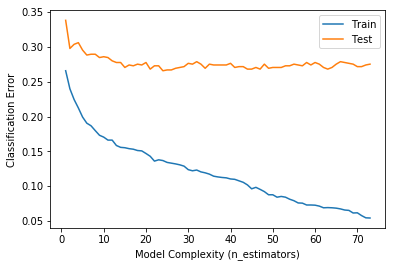

In [53]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['error']
test_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, test_error, label='Test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

In [54]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['fighter1', 'fighter2', 'weight_class',
                                      'title_fight', 'height_fighter1',
                                      'reach_fighter1', 'born_year_fighter1',
                                      'height_fighter2', 'reach_fighter2',
                                      'born_year_fighter2'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'fighter1',
                                          'data_type': dtype('O'),
                                          'm...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_

In [55]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.7390272835112692


In [0]:
columns = ['TD_Def_fighter1','Str_Acc_fighter2','TD_Def_fighter2','Str_Acc_fighter1',
           'born_year_fighter2','born_year_fighter1','height_fighter1','height_fighter2']
X_train_2 = X_train.drop(columns=columns)
X_test_2 = X_test.drop(columns=columns)

In [69]:
pipeline_2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1)
)

pipeline_2.fit(X_train_2, y_train)


print('Test Accuracy', pipeline_2.score(X_test_2, y_test))

Test Accuracy 0.7212336892052195


In [80]:

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train_2, y_train)

y_pred = pipeline.predict(X_test_2)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.7520759193357058


In [85]:
encoder_2 = ce.OrdinalEncoder()
X_train_2_enc = encoder_2.fit_transform(X_train_2)
X_test_2_enc = encoder_2.transform(X_test_2)

eval_set = [(X_train_2_enc, y_train), 
            (X_test_2_enc, y_test)]

model_2 = XGBClassifier(
    n_estimators=1000,
    max_depth=2,  
    learning_rate=0.1,
    n_jobs=-1
)

model_2.fit(X_train_2_enc, y_train, eval_set=eval_set, 
          eval_metric='error', early_stopping_rounds=50)

[0]	validation_0-error:0.371932	validation_1-error:0.341637
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.36286	validation_1-error:0.344009
[2]	validation_0-error:0.332177	validation_1-error:0.352313
[3]	validation_0-error:0.34365	validation_1-error:0.338078
[4]	validation_0-error:0.324973	validation_1-error:0.328588
[5]	validation_0-error:0.317503	validation_1-error:0.339265
[6]	validation_0-error:0.319904	validation_1-error:0.342823
[7]	validation_0-error:0.3127	validation_1-error:0.29656
[8]	validation_0-error:0.311366	validation_1-error:0.294187
[9]	validation_0-error:0.307631	validation_1-error:0.291815
[10]	validation_0-error:0.302295	validation_1-error:0.290629
[11]	validation_0-error:0.302028	validation_1-error:0.283511
[12]	validation_0-error:0.299893	validation_1-error:0.291815
[13]	validation_0-error:0.300694	validation_1-error:0.290629


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)